In [1]:
import torch
from torch import optim, nn
import h5py

from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset, DataLoader

In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path):
        self.h5file = h5py.File(path, 'r')
        self.images = list(self.h5file.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):    
        filename = self.images[idx]
        image = self.h5file[filename][:, :, :-1].astype(np.float32)
        image = (image - 10000) / 10000

        return np.moveaxis(image, -1, 0)
    
    def __del__(self):
        self.h5file.close()

train_ds = SatelliteDataset("datasets/landsat8.hdf5")
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

In [3]:
next(iter(train_dl)).shape

torch.Size([256, 7, 85, 85])

In [4]:
#https://www.researchgate.net/figure/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the_fig2_348947034
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mha = nn.MultiheadAttention(emb_dim, num_heads=4, batch_first=True) ##2?

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            #nn.Dropout(0.1),
        )

    def forward(self, x):
        x_ln = self.ln1(x)
        att, _ = self.mha(x_ln, x_ln, x_ln)
        
        att = self.ln2(att + x)
        return self.mlp(att) + att

In [5]:
#https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585
class MyMAE(nn.Module):
    def __init__(self, in_c, img_size, patch_size, emb_dim):
        super().__init__()
        assert img_size % patch_size == 0

        self.emb_dim = emb_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (self.img_size // self.patch_size) ** 2

        self.patch_embedding = nn.Conv2d(in_c, self.emb_dim, 
                                         kernel_size=patch_size, 
                                         stride=patch_size,
                                         bias=False)

        self.pos_embedding = nn.Parameter(torch.zeros(self.num_patches, self.emb_dim))
        torch.nn.init.normal_(self.pos_embedding, std=.02)
        
        self.encoder = nn.Sequential(*[Transformer(self.emb_dim) for _ in range(10)])
        self.decoder = nn.Sequential(*[Transformer(self.emb_dim) for _ in range(2)])

        self.decoder_emb_dim = self.emb_dim
        self.decoder_emb = nn.Linear(self.emb_dim, self.decoder_emb_dim, bias=False)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder_emb_dim))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.decoder_pos_emb = nn.Parameter(torch.zeros(self.num_patches, self.decoder_emb_dim))
        torch.nn.init.normal_(self.decoder_pos_emb, std=.02)

        self.img_recov = nn.Linear(self.decoder_emb_dim, in_c * (self.patch_size ** 2), bias=True)
        

    def forward(self, x):
        bs, _, _, _ = x.shape
        device = x.device

        patches = self.patch_embedding(x)
        patches = patches.flatten(2, 3).transpose(1, 2)

        masked_entries = int(0.75 * self.num_patches)
        mask = torch.randperm(self.num_patches, device=device) #img size independent?
        mask = mask[:-masked_entries]

        tokens = patches[:, mask, :] + self.pos_embedding[None, mask, :]
        features = self.encoder(tokens)

        ###### bottleneck

        tokens = self.mask_token.repeat(bs, self.num_patches, 1)
        tokens[:, mask, :] = self.decoder_emb(features)

        tokens = tokens + self.decoder_pos_emb[None, :, :]
        features = self.decoder(tokens)

        image = self.img_recov(features)

        image = image.transpose(1,2)
        image = nn.functional.fold(image, 
                                   kernel_size=self.patch_size, 
                                   output_size=self.img_size, 
                                   stride=self.patch_size)
        
        return image

In [6]:
device = "cuda"

model = MyMAE(7, 85, 5, 256).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.2e-4)
mse_loss = nn.MSELoss()

for epoch in range(20):
    mean_loss = 0
    for data in tqdm(train_dl):
        data = data.to(device)

        reconstruction = model(data)
        loss = mse_loss(reconstruction, data)
        mean_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    mean_loss /= len(train_dl)
    print(f"Epoch {epoch} Loss {mean_loss:.4f}")

#0.33

/home/alunos/.pyenv/versions/3.10.12/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 912/912 [03:09<00:00,  4.80it/s]


Epoch 0 Loss 0.6891


100%|██████████| 912/912 [03:10<00:00,  4.80it/s]


Epoch 1 Loss 0.5284


100%|██████████| 912/912 [03:08<00:00,  4.84it/s]


Epoch 2 Loss 0.4555


100%|██████████| 912/912 [03:04<00:00,  4.94it/s]


Epoch 3 Loss 0.4193


100%|██████████| 912/912 [03:05<00:00,  4.92it/s]


Epoch 4 Loss 0.3900


100%|██████████| 912/912 [03:05<00:00,  4.93it/s]


Epoch 5 Loss 0.3722


100%|██████████| 912/912 [03:03<00:00,  4.98it/s]


Epoch 6 Loss 0.3601


100%|██████████| 912/912 [02:57<00:00,  5.13it/s]


Epoch 7 Loss 0.3526


100%|██████████| 912/912 [02:57<00:00,  5.13it/s]


Epoch 8 Loss 0.3451


100%|██████████| 912/912 [02:57<00:00,  5.13it/s]


Epoch 9 Loss 0.3405


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 10 Loss 0.3356


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 11 Loss 0.3297


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 12 Loss 0.3243


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 13 Loss 0.3204


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 14 Loss 0.3161


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 15 Loss 0.3132


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 16 Loss 0.3102


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 17 Loss 0.3073


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]


Epoch 18 Loss 0.3046


100%|██████████| 912/912 [02:57<00:00,  5.14it/s]

Epoch 19 Loss 0.3025


In [7]:
torch.save(model.state_dict(), "model.pth")

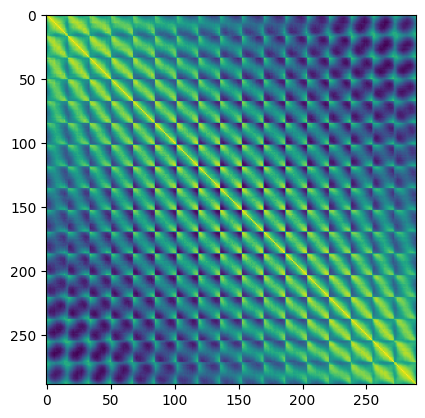

In [8]:
sd = torch.load("model.pth")

import matplotlib.pyplot as plt
plt.imshow(torch.corrcoef(sd['decoder_pos_emb']).cpu().detach().numpy());

odict_keys(['pos_embedding', 'mask_token', 'decoder_pos_emb', 'patch_embedding.weight', 'encoder.0.ln1.weight', 'encoder.0.ln1.bias', 'encoder.0.mha.in_proj_weight', 'encoder.0.mha.in_proj_bias', 'encoder.0.mha.out_proj.weight', 'encoder.0.mha.out_proj.bias', 'encoder.0.ln2.weight', 'encoder.0.ln2.bias', 'encoder.0.mlp.0.weight', 'encoder.0.mlp.0.bias', 'encoder.0.mlp.2.weight', 'encoder.0.mlp.2.bias', 'encoder.1.ln1.weight', 'encoder.1.ln1.bias', 'encoder.1.mha.in_proj_weight', 'encoder.1.mha.in_proj_bias', 'encoder.1.mha.out_proj.weight', 'encoder.1.mha.out_proj.bias', 'encoder.1.ln2.weight', 'encoder.1.ln2.bias', 'encoder.1.mlp.0.weight', 'encoder.1.mlp.0.bias', 'encoder.1.mlp.2.weight', 'encoder.1.mlp.2.bias', 'encoder.2.ln1.weight', 'encoder.2.ln1.bias', 'encoder.2.mha.in_proj_weight', 'encoder.2.mha.in_proj_bias', 'encoder.2.mha.out_proj.weight', 'encoder.2.mha.out_proj.bias', 'encoder.2.ln2.weight', 'encoder.2.ln2.bias', 'encoder.2.mlp.0.weight', 'encoder.2.mlp.0.bias', 'encoder

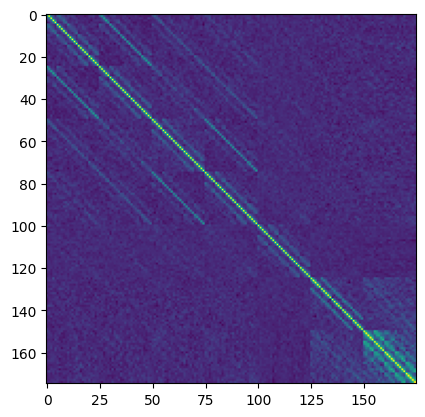

In [9]:
print(sd.keys())
print(sd['img_recov.weight'].shape)
A = sd['img_recov.weight'].flatten(1)#.transpose(0, 1)


plt.imshow(torch.corrcoef(A).cpu().detach().numpy());

In [10]:
for p in sd:
    print(float(sd[p].mean()), float(sd[p].std()), sd[p].shape)

-0.00017346169624943286 0.07908961176872253 torch.Size([289, 256])
-0.00021670095156878233 0.015416540205478668 torch.Size([1, 1, 256])
-3.003602387252613e-06 0.02718910574913025 torch.Size([289, 256])
0.00013778838911093771 0.04222280904650688 torch.Size([256, 7, 5, 5])
0.9419651627540588 0.013071168214082718 torch.Size([256])
0.001453878590837121 0.029069244861602783 torch.Size([256])
0.0001010277119348757 0.042592693120241165 torch.Size([768, 256])
0.00031217894866131246 0.03426220640540123 torch.Size([768])
0.00010178529191762209 0.03454730659723282 torch.Size([256, 256])
-0.00037352769868448377 0.01413954608142376 torch.Size([256])
0.973814070224762 0.019634440541267395 torch.Size([256])
0.00016102025983855128 0.0042526135221123695 torch.Size([256])
-0.0001379312452627346 0.03634818270802498 torch.Size([1024, 256])
-0.002507037715986371 0.03460242971777916 torch.Size([1024])
-1.5285913832485676e-06 0.020063992589712143 torch.Size([256, 1024])
0.0005101917777210474 0.01862673833966

In [11]:
sd['encoder.0.ln1.weight']

tensor([0.9572, 0.9537, 0.9469, 0.9366, 0.9048, 0.9475, 0.9311, 0.9424, 0.9273,
        0.9308, 0.9515, 0.9537, 0.9436, 0.9555, 0.9529, 0.9384, 0.9279, 0.9359,
        0.9469, 0.9591, 0.9535, 0.9448, 0.9481, 0.9377, 0.9459, 0.9500, 0.9272,
        0.9330, 0.9321, 0.9382, 0.9130, 0.9402, 0.9278, 0.9537, 0.9309, 0.9445,
        0.9572, 0.9354, 0.9351, 0.9582, 0.9276, 0.9575, 0.9261, 0.9657, 0.9341,
        0.9580, 0.9459, 0.9436, 0.9550, 0.9487, 0.9403, 0.9459, 0.9458, 0.9488,
        0.9340, 0.9354, 0.9292, 0.9251, 0.9344, 0.9374, 0.9365, 0.9453, 0.9157,
        0.9467, 0.9578, 0.9382, 0.9248, 0.9566, 0.9112, 0.9639, 0.9282, 0.9128,
        0.9326, 0.9625, 0.9281, 0.9536, 0.9411, 0.9185, 0.9411, 0.9501, 0.9459,
        0.9333, 0.9585, 0.9270, 0.9590, 0.9465, 0.9477, 0.9124, 0.9402, 0.9480,
        0.9536, 0.8972, 0.9638, 0.9479, 0.9302, 0.9470, 0.9615, 0.9484, 0.9311,
        0.9495, 0.9374, 0.9545, 0.9261, 0.9451, 0.9314, 0.9432, 0.9580, 0.9580,
        0.9356, 0.9527, 0.9297, 0.9564, 

tensor(-0.0140, device='cuda:0') tensor(0.0374, device='cuda:0')
tensor(0.0114, device='cuda:0') tensor(0.0321, device='cuda:0')
tensor(0.0088, device='cuda:0') tensor(0.0270, device='cuda:0')
tensor(0.0002, device='cuda:0') tensor(0.0258, device='cuda:0')
tensor(-0.0107, device='cuda:0') tensor(0.0423, device='cuda:0')
tensor(0.0033, device='cuda:0') tensor(0.0356, device='cuda:0')
tensor(0.0236, device='cuda:0') tensor(0.0370, device='cuda:0')


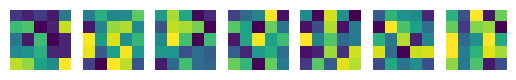

In [12]:
B = sd['img_recov.bias'].unflatten(0, (7, 5, 5))

for i in range(7):
    print(B[i].mean(), B[i].std())
    plt.subplot(1, 7, i + 1)
    plt.imshow(B[i].cpu().detach().numpy())
    plt.axis('off')